In [12]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import pandas as pd
import numpy as np

from itertools import product
from os import path

from itertools import product
from pgmpy.estimators import TreeSearch, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import BIFReader
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianNetwork

In [33]:
df = pd.read_csv(path.join("data", "ehr.csv"))
for col in df.columns:
    print (df[col].value_counts()/len(df))

Parity
1    0.673622
2    0.263359
0    0.063019
Name: count, dtype: float64
Age
1    0.752654
2    0.148602
0    0.098744
Name: count, dtype: float64
BMI
2    0.673500
1    0.315339
0    0.011160
Name: count, dtype: float64
HiBP
0    0.90629
1    0.09371
Name: count, dtype: float64
PReEc
0    0.924607
1    0.075393
Name: count, dtype: float64
PTB
0    0.905865
1    0.094135
Name: count, dtype: float64
NewHTN
0    0.889125
1    0.110875
Name: count, dtype: float64


In [34]:
len(df)

16487

<Axes: >

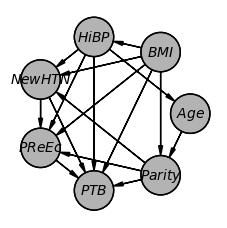

In [20]:
BIFReader(path.join(bn_path, f"ehr-2.bif")).get_model().to_daft().render()

In [13]:
edges = {}
bn_path = "results"
for name in ["numom2b", "garbh-ini", "ehr"]:
    M = BIFReader(path.join(bn_path, f"{name}-2.bif")).get_model()
    edges[name] = (list(M.edges))

from itertools import chain
rows = []
for edge in set(chain.from_iterable(edges.values())):
    rows.append([*edge, *[edge in edges[name] for name in ["numom2b", "garbh-ini", "ehr"]]])

ef = pd.DataFrame(rows, columns = ["first", "second", *["numom2b", "garbh-ini", "ehr"]])
ef

,first,second,numom2b,garbh-ini,ehr
0,Hist,NewHTN,True,False,False
1,Age,NewHTN,True,False,False
2,PReEc,NewHTN,False,True,False
3,Parity,PReEc,False,False,True
4,Parity,PTB,False,True,True
5,Hist,BMI,True,True,False
6,Parity,NewHTN,False,False,True
7,HiBP,PReEc,True,False,True
8,HiBP,PTB,True,True,True
9,BMI,Age,False,True,False


In [15]:
ef["count"] = ef[["numom2b", "ehr", "garbh-ini"]].sum(axis=1)
ef.sort_values(by="count",ascending=False)

,first,second,numom2b,garbh-ini,ehr,count
11,BMI,PTB,True,True,True,3
8,HiBP,PTB,True,True,True,3
21,NewHTN,PTB,True,True,True,3
10,BMI,PReEc,True,True,True,3
22,PReEc,PTB,True,True,True,3
5,Hist,BMI,True,True,False,2
12,HiBP,Age,True,False,True,2
20,BMI,NewHTN,True,False,True,2
19,Age,Parity,False,True,True,2
18,NewHTN,PReEc,True,False,True,2


In [25]:
ef[(ef["count"] == 1)&(ef["ehr"] == True)]

,first,second,numom2b,garbh-ini,ehr,count
3,Parity,PReEc,False,False,True,1
6,Parity,NewHTN,False,False,True,1
13,BMI,Parity,False,False,True,1


In [26]:
ef[(ef["count"] == 1)&(ef["garbh-ini"] == True)]

,first,second,numom2b,garbh-ini,ehr,count
2,PReEc,NewHTN,False,True,False,1
9,BMI,Age,False,True,False,1


In [27]:
ef[(ef["count"] == 1)&(ef["numom2b"] == True)]

,first,second,numom2b,garbh-ini,ehr,count
0,Hist,NewHTN,True,False,False,1
1,Age,NewHTN,True,False,False,1
15,Age,PReEc,True,False,False,1
16,Age,PTB,True,False,False,1


In [11]:
df = pd.read_csv(path.join("data", "numom2b.csv"))
pd.crosstab(df.HiBP, df.NewHTN)

NewHTN,0,1
HiBP,,
0,7592,1510
1,217,49


In [ ]:
def compute_monotonic_influences_from_bn(model: BayesianNetwork, r: list, sign: int, epsilon: float, blacklist: list):
  rows = []
  names = list(model.nodes)
  inference = VariableElimination(model)
  for first, second in product(names, names):
    # Does second influence first? (second -> first)
    # if first == second: continue
    # if first is an ancestor of second, then ignore
    if first in model.get_ancestral_graph(second).nodes: continue
    if (second, first) in blacklist: continue
    
    numerator = inference.query([first, second], show_progress=False)
    denominator = inference.query([second], show_progress=False)
    frange = list(range(r[names.index(first)]))
    srange = list(range(r[names.index(second)]))
    terms = np.array([
      np.cumsum([numerator.get_value(**{first: fval, second: sval}) / denominator.get_value(**{second: sval})
                 for fval in frange[:-1]])
      for sval in srange
    ]).T
    #  first is influenced by second

    diffs = np.fromiter((
      sign * (row[vj1] - row[vj2])
      for row in terms
      for vj2, vj1 in product(srange, srange)
      if vj2 > vj1
    ), dtype=float)

    C = np.all((diffs) + epsilon > 0)
    degree = C * np.sum(diffs) / len(srange)
    rows.append((first, second, degree))

  return pd.DataFrame(rows, columns=("First", "Second", "Degree"))

In [ ]:
bn_path = "results"
bn_name = "numom2b-2"
blacklist = [(row.X, row.Y) for i, row in pd.read_csv("black_list.csv").iterrows()]

M = BIFReader(path.join(bn_path, f"{bn_name}.bif")).get_model()
df1 = compute_monotonic_influences_from_bn(M, [len(M.states[n]) for n in M.nodes], +1, -1e-3, blacklist)
df1 = df1[["Second", "First", "Degree"]]
df1.columns = ["X", "Y", "Degree"]
df1[df1.Degree > 1e-4]

In [ ]:
bn_path = "results"
bn_name = "garbh-ini-2"
blacklist = [(row.X, row.Y) for i, row in pd.read_csv("black_list.csv").iterrows()]

M = BIFReader(path.join(bn_path, f"{bn_name}.bif")).get_model()
df2 = compute_monotonic_influences_from_bn(M, [len(M.states[n]) for n in M.nodes], +1, -1e-3, blacklist)
df2 = df2[["Second", "First", "Degree"]]
df2.columns = ["X", "Y", "Degree"]
df2[df2.Degree > 1e-4]

In [ ]:
df1 = df1[df1.Degree > 1e-4]
df2 = df2[df2.Degree > 1e-4]

def get_degree2(row):
    
    result = df2.query(f"(X == '{row.X}') & (Y == '{row.Y}')")
    if len(result) > 0:
        return result.Degree.item()
    else:
        return 0

df1["Degree2"] = df1.apply(get_degree2, axis=1)

In [ ]:
df1

In [ ]:
def get_degree1(row):
    
    result = df1.query(f"(X == '{row.X}') & (Y == '{row.Y}')")
    if len(result) > 0:
        return result.Degree.item()
    else:
        return 0

df2["Degree1"] = df2.apply(get_degree1, axis=1)

In [ ]:
df2

In [ ]:
M.to_daft().render()

<Axes: >

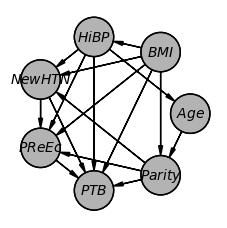

In [6]:
bn_name = "ehr-2"
bn_path = "results"
M = BIFReader(path.join(bn_path, f"{bn_name}.bif")).get_model()

M.to_daft().render()

In [ ]:
df = pd.read_csv(path.join("data", "numom2b.csv"))
df["NewHTN"] = ((df.NewHTN == 1) & (df.HiBP == 0)).astype(int)
pd.crosstab(df.HiBP, df.NewHTN, normalize=0) 

In [ ]:
# HighBP and NewHTN are never true together
# HighBP -> PReEc
# NewHTN -> PReEc
pd.crosstab(df.HiBP, df.PReEc, normalize=0)

In [ ]:

pd.crosstab(df.NewHTN, df.PReEc)